**Stack Exchange - Data Scraping for Questions and Tags**

We want to scrape the distributions of numbers of Questions & Tags for the webpage [Stack Echange - ask ubuntu](https://askubuntu.com/) to see if we find anything interesting. To do this, we’ll first scrape data related to Questions and Tags from Stack Exchange webpage for all the respective pages.


**Working out which pages to scrape**

  Once we've defined our goal, we then need to identify an efficient set of pages to scrape. In order to scrape data from the respective web pages, we use the `request` library. A request is what happens when we access a web page. We 'request' the content of a page from the server.

In [1]:
# Importing all the required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import requests
from requests import get
import regex as re
from requests import get
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS
import timeit
import nltk
from nltk.util import *
from nltk.corpus import stopwords
import re
import seaborn as sns
from collections import defaultdict

In [2]:
url = 'https://askubuntu.com/questions'
time.sleep(5)
# Getting the response from the source URL.
response = get(url)
print(response.text[:500])

<!DOCTYPE html>


    <html class="html__responsive">

    <head>

        <title>Newest Questions - Ask Ubuntu</title>
        <link rel="shortcut icon" href="https://cdn.sstatic.net/Sites/askubuntu/Img/favicon.ico?v=928dfb7c1990">
        <link rel="apple-touch-icon" href="https://cdn.sstatic.net/Sites/askubuntu/Img/apple-touch-icon.png?v=e16e1315edd6">
        <link rel="image_src" href="https://cdn.sstatic.net/Sites/askubuntu/Img/apple-touch-icon.png?v=e16e1315edd6"> 
        <lin


As we can see from the first line of response.text, the server sent us an HTML document. This document describes the overall structure of that web page, along with its specific content (which is what makes that particular page unique).

In [3]:
# Parsing respose.txt by creating a BeautifulSoup object and assigning it to htlm_soup.
time.sleep(5)
html_soup = BeautifulSoup(response.text, 'html.parser')


In [4]:
# Printing the total questions summary for each page (pagination set to 50 for viewing purpose)
# The div tag has a class named question-summary that displays to us the entire information for a question posted.

Questions_EachPage = html_soup.find_all('div', class_ = 'question-summary')
print(type(Questions_EachPage))
print(len(Questions_EachPage))

<class 'bs4.element.ResultSet'>
50


As we can see the question summary class count comes out to be 50, which is what we had expected depending on the pagination that we have set.

However, we are only interested to scrape the Questions from this summary and not other things like time, comments, votes, answers,views etc. So, we will only deal with the tag `<h3>` and `<a>`.

**Extracting data for a single question:**


In [5]:
# Printing out the HTLM content of our first question.

first_question = Questions_EachPage[0]
print(first_question)

<div class="question-summary" id="question-summary-1288524">
<div class="statscontainer">
<div class="stats">
<div class="vote">
<div class="votes">
<span class="vote-count-post"><strong>0</strong></span>
<div class="viewcount">votes</div>
</div>
</div>
<div class="status unanswered">
<strong>0</strong>answers
            </div>
</div>
<div class="views" title="3 views">
    3 views
</div>
</div>
<div class="summary">
<h3><a class="question-hyperlink" href="/questions/1288524/what-editions-of-wubi-input-method-do-the-various-wubi-packages-in-ubuntu-impl">What edition(s) of wubi input method do the various wubi packages in Ubuntu implement?</a></h3>
<div class="excerpt">
            I'm talking about packages that provide the wubi (五筆) input method for the Chinese language, not the "Windows-based Ubuntu Installer".
I see that there are at least these packages that ...
        </div>
<div class="tags t-input-method t-chinese">
<a class="post-tag" href="/questions/tagged/input-method" rel

As we can see, the HTML content of one container is very long. To find out the HTML line specific to each data point, we’ll use DevTools once again.

In [6]:
# Hitting the webpage to validate if there are any timeouts or connection reset warnings using try except()

from urllib.request import urlopen 
from socket import timeout

url = "https://askubuntu.com/questions?tab=newest&pagesize=50"
try: 
    string = urlopen(url, timeout=5).read()
except ConnectionResetError:
    print("==> ConnectionResetError")
    pass
except timeout: 
    print("==> Timeout")
    pass

In [7]:
pages_list=[]                         # Empty list that will be appended with the page count

pages_list.append("https://askubuntu.com/questions?tab=newest&pagesize=50")

for page in list(range(2, 601)):     # Looping over first 400 webpages

  pages_list.append('https://askubuntu.com/questions?tab=newest&page='+str(page))
  
print(len(pages_list))

600


In [8]:
questions_list=[]                     # Creating an empty list of questions that will be appended with the question counts.

# time.sleep(5)
for x in pages_list:                  # Looping over all the pages in the page list
  page = requests.get(x)
  soup = BeautifulSoup(page.text, 'html.parser')

  question_name = soup.find_all('h3')   # Finding the h3 tag that has details of the question
  for question in question_name:
        if question.find('a'):
            questions_list.append(question.find('a').text)

In [9]:
# Printing the length of the questions scraped and the top 10 questions.

print(len(questions_list))
print(questions_list[:11])

31200
['current community', 'more stack exchange communities', 'What edition(s) of wubi input method do the various wubi packages in Ubuntu implement?', 'How do I increase the physical space for WSL2', "Ubuntu 20.04.1 LTS upgrade, dock icons and panel doesn't show correctly", 'How to remap Microsoft Ergonomic Keyboard 2019 model the Office and the Emoji keys?', 'Does client OS verify packages downloaded from Ubuntu main repository?', 'How to use KDE global menu with Firefox?', 'After last update my Ubuntu 20.04.1 became unbootable', 'ssh time restrictions after ubuntu upgrade', 'why is my user systemd.service static']


In [10]:
# To get the tags from the webpage

def ListToString(string):
  # initialize an empty string 
  string1 = ""
    
  # traverse in the string   
  for element in string:  
      string1 = string1 + element   
     
  return string1


tag=[]

for x in pages_list:
  page = requests.get(x)
  soup = BeautifulSoup(page.text, 'html.parser')

  tags=[]

  for div in soup.find_all('div', {"class": re.compile("^tags")}):      
    tags.append(div.get('class')[1:])



  clean_tags=[]

  for i in tags:
    clean_tags.append(ListToString(i).replace('t-','|'))



  for j in clean_tags:
    tag.append(j[1:])

In [11]:
print(len(tag))
print(tag[:11])

30000
['apt|python', 'inpu|method|chinese', 'windows|virtualization|windows-subsystem-for-linux', 'upgrade|20û04|icons|dock', 'keyboard|shortcu|keys|microsof|keyboard', 'package-management|security|repository|signature|pgp', 'firefox|plasma-5|kde5|globalmenu', 'upgrade|kernel|updates', 'upgrade|ssh', '20û04|systemd', 'boot|live-usb|usb-installation|20û10']


In [12]:
# Creating a dataframe for questions and tags

ask_ubuntu_df = pd.DataFrame(list(zip(tag, questions_list)), columns =['Tags', 'Questions']) 
ask_ubuntu_df.head(10)

,Tags,Questions
0,apt|python,current community
1,inpu|method|chinese,more stack exchange communities
2,windows|virtualization|windows-subsystem-for-l...,What edition(s) of wubi input method do the va...
3,upgrade|20û04|icons|dock,How do I increase the physical space for WSL2
4,keyboard|shortcu|keys|microsof|keyboard,"Ubuntu 20.04.1 LTS upgrade, dock icons and pan..."
5,package-management|security|repository|signatu...,How to remap Microsoft Ergonomic Keyboard 2019...
6,firefox|plasma-5|kde5|globalmenu,Does client OS verify packages downloaded from...
7,upgrade|kernel|updates,How to use KDE global menu with Firefox?
8,upgrade|ssh,After last update my Ubuntu 20.04.1 became unb...
9,20û04|systemd,ssh time restrictions after ubuntu upgrade


In [13]:
# Creating a func() called build_ngrams to analyse data in the form of unigrams, bigrams, ngrams etc.

def build_ngrams(ask_ubuntu_text, ngram):
    ask_ubuntu_text = ask_ubuntu_text.lower()
    ask_ubuntu_text = remove_space.sub(' ', ask_ubuntu_text)
    ask_ubuntu_text = bad_symbols.sub(' ', ask_ubuntu_text)
    ask_ubuntu_text = ' '.join(word for word in ask_ubuntu_text.split() if word not in STOPWORDS) 
    tokenize = nltk.word_tokenize(ask_ubuntu_text)
    return list(ngrams(tokenize, ngram))

In [14]:
# Handling spaces in text and bad symbols and eliminating those using regex.

remove_space = re.compile('[/(){}\[\]\|@,;]')
bad_symbols = re.compile('[^a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

In [15]:
# Looping over questions list and building unigrams from the list.

onegram_tags_freq = defaultdict(int)
for sentence in ask_ubuntu_df['Questions']:
    for word in build_ngrams(sentence, 1):
        onegram_tags_freq[word] = onegram_tags_freq[word] + 1

In [20]:
def plot_horizontal_bar(data, title):
    plt.figure(figsize=(20, 15))
    freq = pd.DataFrame(sorted(data.items(), key=lambda x: x[1]), columns=['Words','Count'])
    sns.barplot(x='Count', y='Words', data=freq.sort_values(by="Count", ascending=True).tail(30))
    plt.title(title)
    plt.tight_layout()
    plt.show()

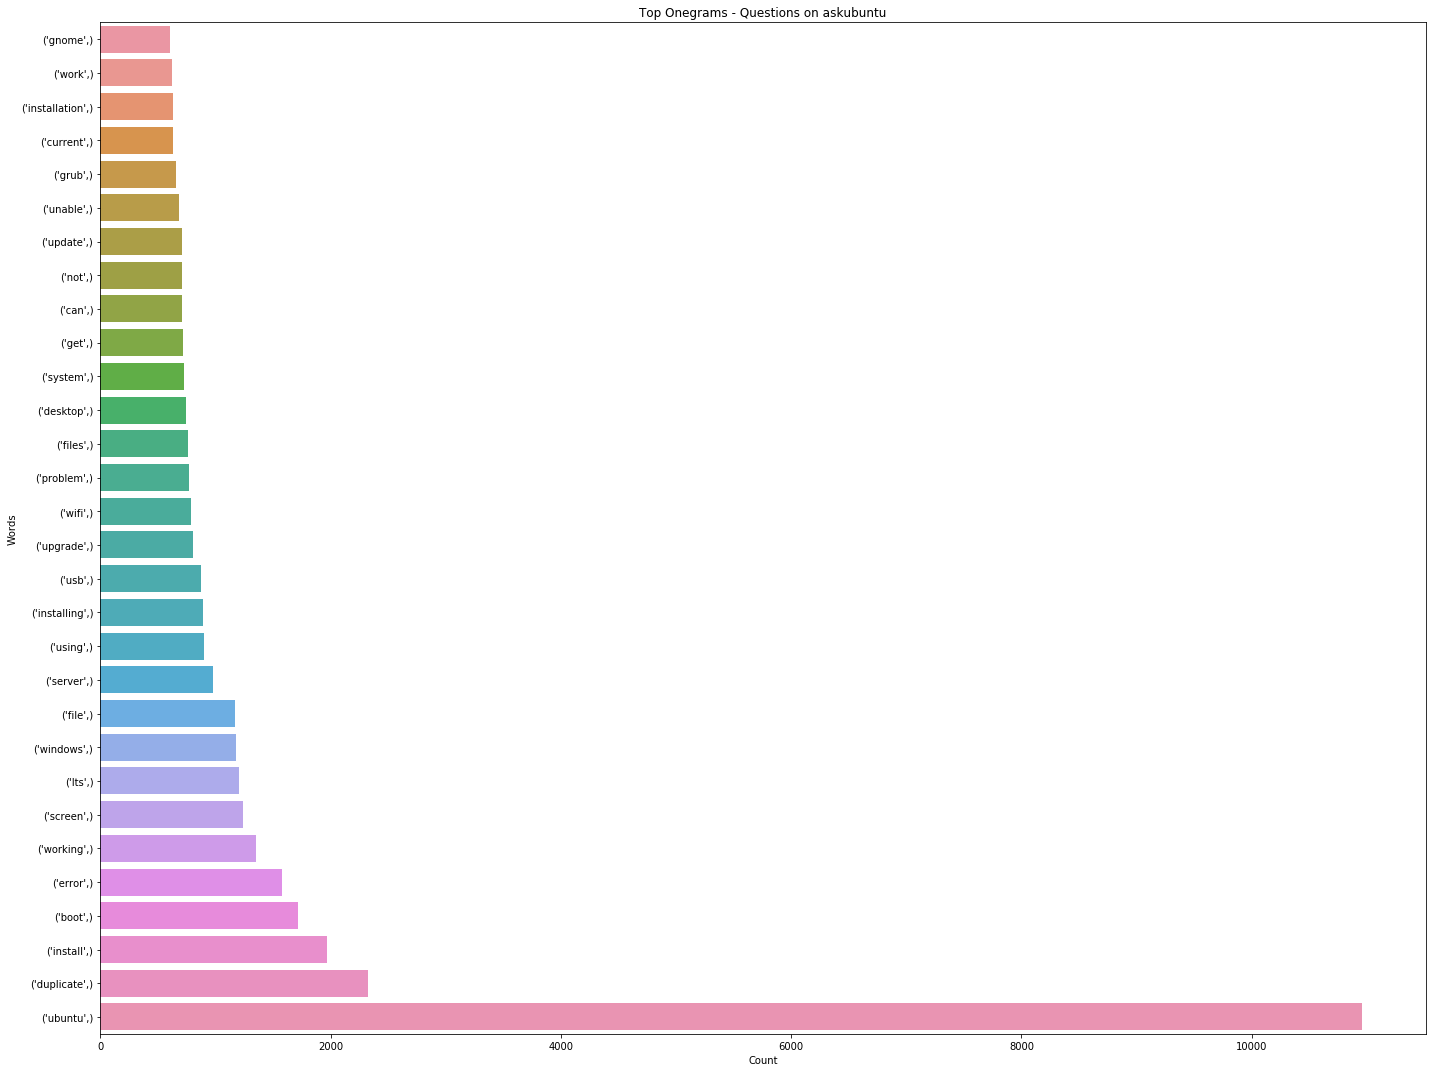

In [21]:
plot_horizontal_bar(onegram_tags_freq, 'Top Onegrams - Questions on askubuntu')

In [22]:
# Looping over questions list and building bigrams from the list.

bigrams_tags_freq = defaultdict(int)
for sentence in ask_ubuntu_df['Questions']:
    for word in build_ngrams(sentence, 2):
        bigrams_tags_freq[word] = bigrams_tags_freq[word] + 1

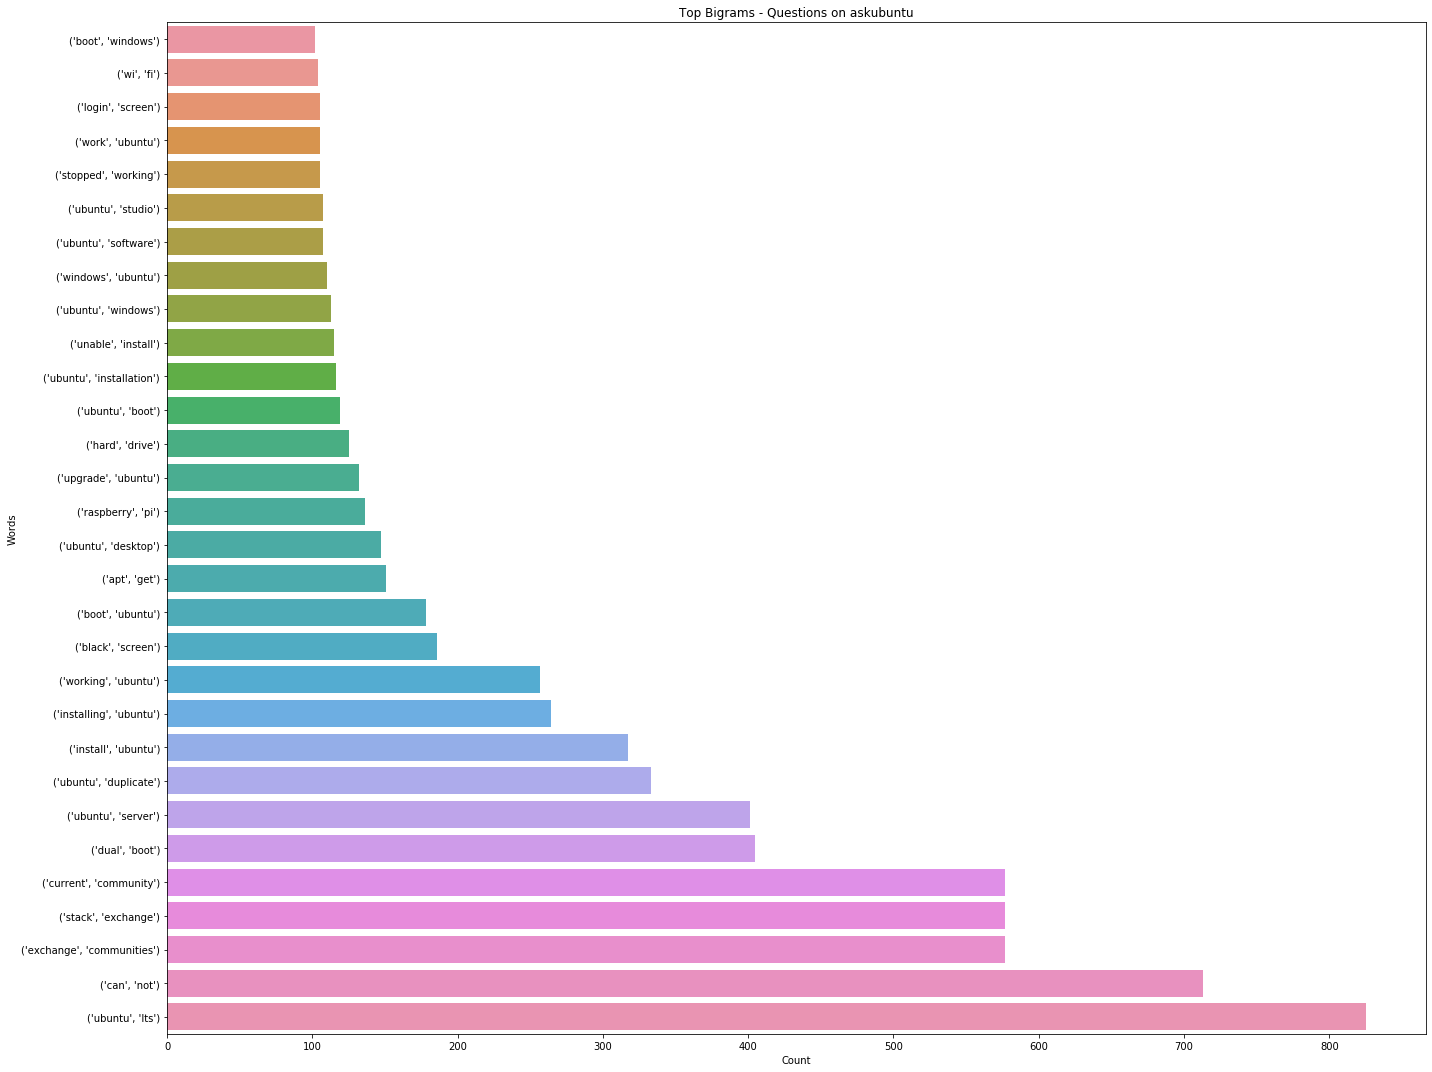

In [23]:
plot_horizontal_bar(bigrams_tags_freq, 'Top Bigrams - Questions on askubuntu')

In [24]:
# Removing special characters, hyperlinks/URL's from the Questions and Tags.

ask_ubuntu_df['Questions'] = ask_ubuntu_df['Questions'].str.replace('()','')
ask_ubuntu_df['Questions'] = ask_ubuntu_df['Questions'].str.replace(';','')
ask_ubuntu_df['Questions'] = ask_ubuntu_df['Questions'].str.replace(':','')
ask_ubuntu_df['Questions'] = ask_ubuntu_df['Questions'].str.replace('/','')


ask_ubuntu_df['Tags'] = ask_ubuntu_df['Tags'].str.replace('()','')
ask_ubuntu_df['Tags'] = ask_ubuntu_df['Tags'].str.replace(';','')
ask_ubuntu_df['Tags'] = ask_ubuntu_df['Tags'].str.replace(':','')
ask_ubuntu_df['Tags'] = ask_ubuntu_df['Tags'].str.replace('û','.')
ask_ubuntu_df['Tags'] = ask_ubuntu_df['Tags'].str.replace('\t','')

In [25]:
# Joining all the tags and storing those in a variable for plotting in a wordcloud
ask_ubuntu_tags = ' '.join(ask_ubuntu_df['Tags'].str.lower())

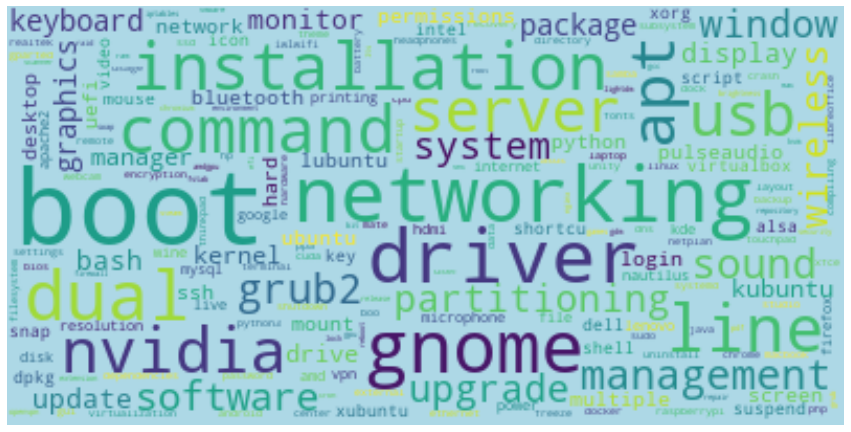

In [26]:
wordcloud = WordCloud(max_font_size=50, collocations=False, background_color='lightblue').generate(ask_ubuntu_tags)
plt.figure(figsize=(15,12))
# plot wordcloud in matplotlib
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [27]:
ask_ubuntu_df["Tags"] = [item.replace("|", " __label__") for item in ask_ubuntu_df["Tags"]]
ask_ubuntu_df['Tags'] ='__label__' + ask_ubuntu_df['Tags'].astype(str)
ask_ubuntu_df.head()

,Tags,Questions
0,__label__apt __label__python,current community
1,__label__inpu __label__method __label__chinese,more stack exchange communities
2,__label__windows __label__virtualization __lab...,What edition(s) of wubi input method do the va...
3,__label__upgrade __label__20.04 __label__icons...,How do I increase the physical space for WSL2
4,__label__keyboard __label__shortcu __label__ke...,"Ubuntu 20.04.1 LTS upgrade, dock icons and pan..."


In [28]:
# Setting the current working directory

relative_path = "/Users/Agam/Project Files/"
os.chdir(relative_path)

In [ ]:
# Cloning and Installing fastText
!git clone https://github.com/facebookresearch/fastText.git
%cd fastText
!make
!cp fasttext ../
%cd ..

In [30]:
# Changing the respective path to the fastText directory after cloning fastText.

relative_path = "/Users/Agam/Project Files/fastText"
os.chdir(relative_path)

In [31]:
# Save the DataFrame as a .txt file which is required for feeding to fastText

np.savetxt('ask_ubuntu.txt', ask_ubuntu_df.values, fmt='%s', delimiter='\t')

In [32]:
!head "/Users/Agam/Project Files/fastText/ask_ubuntu.txt"

__label__apt __label__python	current community
__label__inpu __label__method __label__chinese	more stack exchange communities
__label__windows __label__virtualization __label__windows-subsystem-for-linux	What edition(s) of wubi input method do the various wubi packages in Ubuntu implement?
__label__upgrade __label__20.04 __label__icons __label__dock	How do I increase the physical space for WSL2
__label__keyboard __label__shortcu __label__keys __label__microsof __label__keyboard	Ubuntu 20.04.1 LTS upgrade, dock icons and panel doesn't show correctly
__label__package-management __label__security __label__repository __label__signature __label__pgp	How to remap Microsoft Ergonomic Keyboard 2019 model the Office and the Emoji keys?
__label__firefox __label__plasma-5 __label__kde5 __label__globalmenu	Does client OS verify packages downloaded from Ubuntu main repository?
__label__upgrade __label__kernel __label__updates	How to use KDE global menu with Firefox?
__label__upgrade __label__ssh	Af

In [33]:
# Splitting the data into training, validation and testing.

train_data= round(len(ask_ubuntu_df)*0.70)
validation_data = round(len(ask_ubuntu_df)*0.15)
testing_data = round(len(ask_ubuntu_df)*0.15) 

print("Number of records for training dataset are:", train_data)
print("Number of records for validation dataset are:", validation_data)
print("Number of records for testing dataset are:", testing_data)

Number of records for training dataset are: 21000
Number of records for validation dataset are: 4500
Number of records for testing dataset are: 4500


In [34]:
ask_ubuntu_df.head(10)

,Tags,Questions
0,__label__apt __label__python,current community
1,__label__inpu __label__method __label__chinese,more stack exchange communities
2,__label__windows __label__virtualization __lab...,What edition(s) of wubi input method do the va...
3,__label__upgrade __label__20.04 __label__icons...,How do I increase the physical space for WSL2
4,__label__keyboard __label__shortcu __label__ke...,"Ubuntu 20.04.1 LTS upgrade, dock icons and pan..."
5,__label__package-management __label__security ...,How to remap Microsoft Ergonomic Keyboard 2019...
6,__label__firefox __label__plasma-5 __label__kd...,Does client OS verify packages downloaded from...
7,__label__upgrade __label__kernel __label__updates,How to use KDE global menu with Firefox?
8,__label__upgrade __label__ssh,After last update my Ubuntu 20.04.1 became unb...
9,__label__20.04 __label__systemd,ssh time restrictions after ubuntu upgrade


In [35]:
training_data =pd.read_table("/Users/Agam/Project Files/fastText/ask_ubuntu.txt", nrows=train_data,header=None,error_bad_lines=False)
valid_data =pd.read_table("/Users/Agam/Project Files/fastText/ask_ubuntu.txt",skiprows=train_data,nrows=validation_data,header=None,error_bad_lines=False)

In [36]:
# Saving the training and validation files.

np.savetxt('/Users/Agam/Project Files/fastText/ask_ubuntu.train', training_data.values, fmt='%s', delimiter='\t')
np.savetxt('/Users/Agam/Project Files/fastText/ask_ubuntu.val', valid_data.values, fmt='%s', delimiter='\t')

In [37]:
!./fasttext  supervised -input "/Users/Agam/Project Files/fastText/ask_ubuntu.train" -output ./unprocessed_model

Read 0M words
Number of words:  23114
Number of labels: 2125
Progress: 100.0% words/sec/thread:    8920 lr:  0.000000 avg.loss: 10.344991 ETA:   0h 0m 0s ETA:   0h 0m 6s


In [38]:
# Validating model accuracy on the validation set.

!./fasttext test ./unprocessed_model.bin "/Users/Agam/Project Files/fastText/ask_ubuntu.val"

N	4494
P@1	0.282
R@1	0.0926


**As we can see that when the passed the train data to the fastText Model without pre-processing, the model gave a precision of 28%**

In [39]:
cat "/Users/Agam/Project Files/fastText/ask_ubuntu.txt" | sed -e "s/\([.\!?,'/()]\)/ \1 /g" | tr "[:upper:]" "[:lower:]" > "/Users/Agam/Project Files/fastText/ask_ubuntu.cleaned.txt"


Now we are cleaning pre-processing the data a bit by using the sed command and applying fasttext on the default model without any tuning any hyper parameters.

In [40]:
training_data =pd.read_table("/Users/Agam/Project Files/fastText/ask_ubuntu.cleaned.txt", nrows=train_data,header=None, error_bad_lines=False)
valid_data =pd.read_table("/Users/Agam/Project Files/fastText/ask_ubuntu.cleaned.txt",skiprows=train_data,nrows=validation_data,header=None)

In [41]:
np.savetxt('/Users/Agam/Project Files/fastText/ask_ubuntu.train', training_data.values, fmt='%s', delimiter='\t')
np.savetxt('/Users/Agam/Project Files/fastText/ask_ubuntu.val', valid_data.values, fmt='%s', delimiter='\t')

Storing and saving the cleaned data files in the desired path.

In [42]:
!./fasttext  supervised -input "/Users/Agam/Project Files/fastText/ask_ubuntu.train" -output ./preprocessed_model

Read 0M words
Number of words:  14775
Number of labels: 2112
Progress: 100.0% words/sec/thread:   11396 lr:  0.000000 avg.loss: 10.147679 ETA:   0h 0m 0sh 0m 1s10.139883 ETA:   0h 0m 0s


In [43]:
!./fasttext test ./preprocessed_model.bin "/Users/Agam/Project Files/fastText/ask_ubuntu.val"

N	4494
P@1	0.317
R@1	0.104


As we can see from the model output, that pre-processing the data led to increase in precision (around 4%). Now, we can tune in and apply hyper parameters to have a look how the model precision improves in the process.